#### Analysis of Commodities through evaluating NLP and ARIMA Modeling

In [208]:
import os
import pandas as pd
from pathlib import Path
from newsapi import NewsApiClient
import numpy as np
from dotenv import load_dotenv
load_dotenv()
import alpaca_trade_api as tradeapi
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import json
get_ipython().run_line_magic("matplotlib", "inline")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



### Sentiment Analysis from the news

##### VADER Lexicon is installed from the Natural Language Toolkit. VADER was developed as an alternative to other lexicons in existance, the primary purpose of it was to use both quantitative and qualitative data to analyze micro-blogging sentiment. However, it can also be extended for use in analyzing newspaper articles-- as I've chosen to do here to assess author sentiments towards 5 commidities and Bitcoin. 

###### Source: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [192]:
# Download/Update the VADER Lexicon
nltk.download("vader_lexicon")

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jacqueline/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [193]:
api_key = os.getenv("news_api")

In [194]:
newsapi = NewsApiClient(api_key=api_key)

In [ ]:
#Get the commodities headlines for Corn, Wheat, Oil, Gold, and Coffee from NewsAPI
commodities_headlines = newsapi.get_everything(q="corn" and "wheat" and "oil" and "coffee" and "gold", language="en", sort_by="relevancy", page_size=100)
commodities_headlines

In [201]:
#Create a dataframe from the returned results 
commodities_df = pd.DataFrame.from_dict(commodities_headlines["articles"])
commodities_df.tail()

,source,author,title,description,url,urlToImage,publishedAt,content
95,"{'id': 'reuters', 'name': 'Reuters'}",Amal S,CANADA STOCKS-Toronto index up on boost from e...,Canada's commodity-heavy main stock index rose...,https://www.reuters.com/article/canada-stocks-...,https://s1.reutersmedia.net/resources_v2/image...,2021-11-04T14:04:00Z,"(Updates prices, adds analyst comment)\r\nNov ..."
96,"{'id': 'reuters', 'name': 'Reuters'}",Reuters Staff,PRECIOUS-Gold rebounds as dollar dips after Fe...,Gold prices bounced back from a three-week low...,https://www.reuters.com/article/global-preciou...,https://s1.reutersmedia.net/resources_v2/image...,2021-11-04T01:29:00Z,By Reuters Staff\r\nNov 4 (Reuters) - Gold pri...
97,"{'id': 'reuters', 'name': 'Reuters'}",Foo Yun Chee,Beefed up EU tech rules could be global standa...,Europe's draft rules requiring tech firms to d...,https://www.reuters.com/article/facebook-hauge...,https://static.reuters.com/resources/r/?m=02&d...,2021-11-08T18:41:00Z,BRUSSELS (Reuters) - Europes draft rules requi...
98,"{'id': 'reuters', 'name': 'Reuters'}",Nakul Iyer,PRECIOUS-Gold set for second week of gains on ...,Gold was poised for a second weekly gain on Fr...,https://www.reuters.com/article/global-preciou...,https://s1.reutersmedia.net/resources_v2/image...,2021-10-22T04:24:00Z,"(Recasts, adds comment and updates prices)\r\n..."
99,"{'id': 'reuters', 'name': 'Reuters'}",None,Olympic champion Warner seeks entry to elite d...,Damian Warner may have won decathlon gold at t...,https://www.reuters.com/lifestyle/sports/olymp...,https://www.reuters.com/resizer/CFnp3SGF97ajWX...,2021-10-15T17:27:00Z,FILE PHOTO-Tokyo 2020 Olympics - Athletics - M...


In [277]:
#Pickle the data so we can access it again 
#pickle.dump(commodities_df, open( "save.p", "wb" ) )
commodities_df = pickle.load( open( "save.p", "rb" ) )
commodities_df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': 'wired', 'name': 'Wired'}",Kylie Mohr,This Prairie Grassland Project Collects Native...,Young members of the Fort Belknap Indian Commu...,https://www.wired.com/story/this-prairie-grass...,https://media.wired.com/photos/617303503007966...,2021-10-23T12:00:00Z,The BLM funds the partnership along with priva...
1,"{'id': 'reuters', 'name': 'Reuters'}",None,Corteva faces slow start as it takes aim at Ba...,U.S. pesticide and seed maker Corteva Inc <a h...,https://www.reuters.com/business/corteva-faces...,https://www.reuters.com/resizer/EGlB3ZJICxQYKp...,2021-10-08T11:05:00Z,A worker inspects soybeans during the soy harv...
2,"{'id': 'wired', 'name': 'Wired'}",Medea Giordano,15 Smart Gifts to Upgrade Your Beauty Routine,Give your loved ones the gift of feeling fabul...,https://www.wired.com/gallery/gift-ideas-for-h...,https://media.wired.com/photos/5fbda0acd840498...,2021-10-22T13:00:00Z,Makeup creates a ton of waste. Once you're don...
3,"{'id': None, 'name': 'ReadWrite'}",Ali Hasnain,Steps to Find a Black Seed Oil Buyer Online,Setting up your own international trading busi...,https://readwrite.com/2021/10/28/steps-to-find...,https://images.readwrite.com/wp-content/upload...,2021-10-28T14:01:01Z,Setting up your own international trading busi...
4,"{'id': 'reuters', 'name': 'Reuters'}",None,ATP roundup: Frances Tiafoe upsets No. 1 Stefa...,"After falling behind 3-0 in the deciding set, ...",https://www.reuters.com/lifestyle/sports/atp-r...,https://www.reuters.com/resizer/kVWb0vnoOguhKh...,2021-10-28T22:15:00Z,Tokyo 2020 Olympics - Tennis - Men's Singles -...


### Run the sentiment scores on text and title with VADER 

In [278]:
for index, row in commodities_df['description'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    if score['neg'] > score['pos']:
        commodities_df.loc[index, "Sentiment"] = "negative"
    elif score['pos'] > score['neg']:
        commodities_df.loc[index, "Sentiment"] = "positive"
    else:
        commodities_df.loc[index, "Sentiment"] = "neutral"
        
    commodities_df.loc[index, 'neg'] = score['neg']
    commodities_df.loc[index, 'neu'] = score['neu']
    commodities_df.loc[index, 'pos'] = score['pos']
    commodities_df.loc[index, 'compound'] = score['compound']
    
commodities_df.head(10)

,source,author,title,description,url,urlToImage,publishedAt,content,Sentiment,neg,neu,pos,compound
0,"{'id': 'wired', 'name': 'Wired'}",Kylie Mohr,This Prairie Grassland Project Collects Native...,Young members of the Fort Belknap Indian Commu...,https://www.wired.com/story/this-prairie-grass...,https://media.wired.com/photos/617303503007966...,2021-10-23T12:00:00Z,The BLM funds the partnership along with priva...,positive,0.000,0.816,0.184,0.6597
1,"{'id': 'reuters', 'name': 'Reuters'}",None,Corteva faces slow start as it takes aim at Ba...,U.S. pesticide and seed maker Corteva Inc <a h...,https://www.reuters.com/business/corteva-faces...,https://www.reuters.com/resizer/EGlB3ZJICxQYKp...,2021-10-08T11:05:00Z,A worker inspects soybeans during the soy harv...,positive,0.000,0.924,0.076,0.4215
2,"{'id': 'wired', 'name': 'Wired'}",Medea Giordano,15 Smart Gifts to Upgrade Your Beauty Routine,Give your loved ones the gift of feeling fabul...,https://www.wired.com/gallery/gift-ideas-for-h...,https://media.wired.com/photos/5fbda0acd840498...,2021-10-22T13:00:00Z,Makeup creates a ton of waste. Once you're don...,positive,0.000,0.485,0.515,0.8934
3,"{'id': None, 'name': 'ReadWrite'}",Ali Hasnain,Steps to Find a Black Seed Oil Buyer Online,Setting up your own international trading busi...,https://readwrite.com/2021/10/28/steps-to-find...,https://images.readwrite.com/wp-content/upload...,2021-10-28T14:01:01Z,Setting up your own international trading busi...,positive,0.000,0.964,0.036,0.1779
4,"{'id': 'reuters', 'name': 'Reuters'}",None,ATP roundup: Frances Tiafoe upsets No. 1 Stefa...,"After falling behind 3-0 in the deciding set, ...",https://www.reuters.com/lifestyle/sports/atp-r...,https://www.reuters.com/resizer/kVWb0vnoOguhKh...,2021-10-28T22:15:00Z,Tokyo 2020 Olympics - Tennis - Men's Singles -...,negative,0.143,0.857,0.000,-0.6124
5,"{'id': 'reuters', 'name': 'Reuters'}",None,Raducanu sent packing by Ukraine's Kostyuk at ...,Ukrainian sixth seed Marta Kostyuk swept aside...,https://www.reuters.com/lifestyle/sports/raduc...,https://www.reuters.com/resizer/Iz6FezNDs5XzC_...,2021-10-29T18:35:00Z,Oct 29 (Reuters) - Ukrainian sixth seed Marta ...,positive,0.000,0.784,0.216,0.8271
6,"{'id': 'reuters', 'name': 'Reuters'}",None,ATP roundup: Stefanos Tsitsipas survives opene...,Top seed Stefanos Tsitsipas of Greece saved th...,https://www.reuters.com/lifestyle/sports/atp-r...,https://www.reuters.com/resizer/Fk311kciMt9reD...,2021-10-26T21:58:00Z,Tokyo 2020 Olympics - Tennis - Men's Singles -...,positive,0.000,0.878,0.122,0.5574
7,"{'id': 'reuters', 'name': 'Reuters'}",None,Novak Djokovic needs three sets for first-roun...,"Top seed Novak Djokovic dropped a set, but the...",https://www.reuters.com/business/cop/novak-djo...,https://www.reuters.com/pf/resources/images/re...,2021-11-03T01:01:00Z,"Top seed Novak Djokovic dropped a set, but the...",negative,0.182,0.676,0.141,-0.4019
8,"{'id': 'reuters', 'name': 'Reuters'}",None,EXCLUSIVE India's price-fixing probe of global...,An Indian antitrust investigation into suspect...,https://www.reuters.com/world/india/exclusive-...,https://www.reuters.com/resizer/F5pOMtEcfZREW2...,2021-11-02T10:55:00Z,"NEW DELHI, Nov 2 (Reuters) - An Indian antitru...",negative,0.128,0.808,0.064,-0.3182
9,"{'id': None, 'name': 'New York Times'}",Tamryn Spruill,"Candace Parker Is the Calm, and the Storm, for...",Parker has known both adversity and success in...,https://www.nytimes.com/2021/10/12/sports/bask...,https://static01.nyt.com/images/2021/10/11/spo...,2021-10-12T09:00:18Z,Copper and Sky Coach James Wade told reporters...,positive,0.149,0.655,0.196,0.3818


In [279]:
#Work Cited below
article_neg = commodities_df[commodities_df["Sentiment"] == "negative"]
article_neu = commodities_df[commodities_df["Sentiment"] == "neutral"]
article_pos = commodities_df[commodities_df["Sentiment"] == "positive"]
#function for calculating the percentage of all the sentiments
def calc_percentage(x,y):
    return x/y * 100
pos_per = calc_percentage(len(article_pos), len(commodities_df))
neg_per = calc_percentage(len(article_neg), len(commodities_df))
neu_per = calc_percentage(len(article_neu), len(commodities_df))
print("positive: {}%".format(len(article_pos), format(pos_per, '.1f')))
print("negative: {}%".format(len(article_neg), format(neg_per, '.1f')))
print("neutral: {}%".format(len(article_neu), format(neu_per, '.1f'))), format(calc_percentage(len(tweet_neu), len(commodities_df_1)), '.1f')

positive: 65%
negative: 24%
neutral: 11%


(None, '11.0')

<BarContainer object of 3 artists>

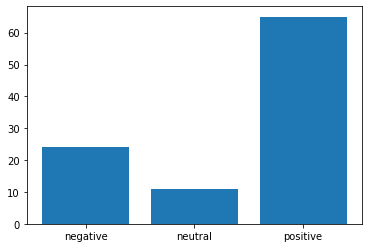

In [280]:
labels = commodities_df.groupby('Sentiment').count().index.values
values = commodities_df.groupby('Sentiment').size().values
plt.bar(labels, values)

In [281]:
#Use lambda function for organizing 'source' results 
commodities_df['source'].apply(lambda s:json.dumps(s)).unique()

array(['{"id": "wired", "name": "Wired"}',
       '{"id": "reuters", "name": "Reuters"}',
       '{"id": null, "name": "ReadWrite"}',
       '{"id": null, "name": "New York Times"}',
       '{"id": "bbc-news", "name": "BBC News"}',
       '{"id": "cbc-news", "name": "CBC News"}',
       '{"id": null, "name": "Sportsnet.ca"}',
       '{"id": null, "name": "The Guardian"}',
       '{"id": null, "name": "Yahoo Entertainment"}',
       '{"id": null, "name": "Blogspot.com"}',
       '{"id": null, "name": "Entrepreneur"}',
       '{"id": null, "name": "Joythebaker.com"}',
       '{"id": null, "name": "Gizmodo.com"}',
       '{"id": null, "name": "Blog.google"}',
       '{"id": null, "name": "WTA Tennis"}',
       '{"id": null, "name": "ESPN"}', '{"id": null, "name": "Forbes"}',
       '{"id": "vice-news", "name": "Vice News"}',
       '{"id": null, "name": "Medium"}',
       '{"id": null, "name": "MarketWatch"}',
       '{"id": null, "name": "Workatastartup.com"}',
       '{"id": null, "name

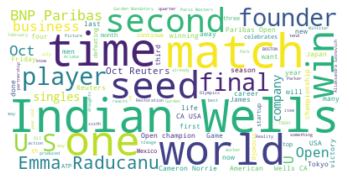

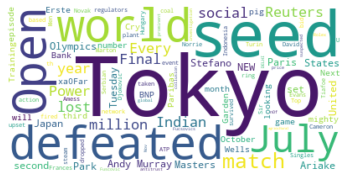

In [282]:
from wordcloud import WordCloud, STOPWORDS
#function to create word cloud
def create_wordcloud(text):
    stopwords = set(STOPWORDS).union(set({'chars', 'tennis', 'round'}))
    wc = WordCloud(background_color = "white", max_words = 100, stopwords = stopwords, repeat = True)
    wc.generate(str(text))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
#word cloud for positive sentiments
create_wordcloud(tweet_pos["content"].values)
#wordcloud for negative sentimenst
create_wordcloud(tweet_neg["content"].values)

In [283]:
"""# Sentiment scores dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# Get sentiment for the text and the title
for index, row in commodities_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["content"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

# Attaching sentiment columns to the News DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
commodities_joined_sentiment = commodities_df.join(title_sentiment_df).join(text_sentiment_df)"""

'# Sentiment scores dictionaries\ntitle_sent = {\n    "title_compound": [],\n    "title_pos": [],\n    "title_neu": [],\n    "title_neg": [],\n    "title_sent": [],\n}\ntext_sent = {\n    "text_compound": [],\n    "text_pos": [],\n    "text_neu": [],\n    "text_neg": [],\n    "text_sent": [],\n}\n\n# Get sentiment for the text and the title\nfor index, row in commodities_df.iterrows():\n    try:\n        # Sentiment scoring with VADER\n        title_sentiment = analyzer.polarity_scores(row["title"])\n        title_sent["title_compound"].append(title_sentiment["compound"])\n        title_sent["title_pos"].append(title_sentiment["pos"])\n        title_sent["title_neu"].append(title_sentiment["neu"])\n        title_sent["title_neg"].append(title_sentiment["neg"])\n        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))\n\n        text_sentiment = analyzer.polarity_scores(row["content"])\n        text_sent["text_compound"].append(text_sentiment["compound"])\n   

In [284]:
commodities_df["createdAt"] = pd.to_datetime(commodities_df["publishedAt"])
commodities_df.set_index(["createdAt"], inplace=True)
commodities_df.head()

,source,author,title,description,url,urlToImage,publishedAt,content,Sentiment,neg,neu,pos,compound
createdAt,,,,,,,,,,,,,
2021-10-23 12:00:00+00:00,"{'id': 'wired', 'name': 'Wired'}",Kylie Mohr,This Prairie Grassland Project Collects Native...,Young members of the Fort Belknap Indian Commu...,https://www.wired.com/story/this-prairie-grass...,https://media.wired.com/photos/617303503007966...,2021-10-23T12:00:00Z,The BLM funds the partnership along with priva...,positive,0.000,0.816,0.184,0.6597
2021-10-08 11:05:00+00:00,"{'id': 'reuters', 'name': 'Reuters'}",None,Corteva faces slow start as it takes aim at Ba...,U.S. pesticide and seed maker Corteva Inc <a h...,https://www.reuters.com/business/corteva-faces...,https://www.reuters.com/resizer/EGlB3ZJICxQYKp...,2021-10-08T11:05:00Z,A worker inspects soybeans during the soy harv...,positive,0.000,0.924,0.076,0.4215
2021-10-22 13:00:00+00:00,"{'id': 'wired', 'name': 'Wired'}",Medea Giordano,15 Smart Gifts to Upgrade Your Beauty Routine,Give your loved ones the gift of feeling fabul...,https://www.wired.com/gallery/gift-ideas-for-h...,https://media.wired.com/photos/5fbda0acd840498...,2021-10-22T13:00:00Z,Makeup creates a ton of waste. Once you're don...,positive,0.000,0.485,0.515,0.8934
2021-10-28 14:01:01+00:00,"{'id': None, 'name': 'ReadWrite'}",Ali Hasnain,Steps to Find a Black Seed Oil Buyer Online,Setting up your own international trading busi...,https://readwrite.com/2021/10/28/steps-to-find...,https://images.readwrite.com/wp-content/upload...,2021-10-28T14:01:01Z,Setting up your own international trading busi...,positive,0.000,0.964,0.036,0.1779
2021-10-28 22:15:00+00:00,"{'id': 'reuters', 'name': 'Reuters'}",None,ATP roundup: Frances Tiafoe upsets No. 1 Stefa...,"After falling behind 3-0 in the deciding set, ...",https://www.reuters.com/lifestyle/sports/atp-r...,https://www.reuters.com/resizer/kVWb0vnoOguhKh...,2021-10-28T22:15:00Z,Tokyo 2020 Olympics - Tennis - Men's Singles -...,negative,0.143,0.857,0.000,-0.6124


In [285]:
#commodities_df_1.index = commodities_df_1.index.date

In [286]:
commodities_df.sort_index(inplace=True)

In [287]:
resampledf = commodities_df.resample('D').mean()

### Set up ARIMA Model

In [288]:
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [289]:
# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes between now and 3 years ago.
start_date = pd.Timestamp("2018-09-11", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-11-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["CORN", "WEAT", "JO", "GLD", "USO"]

# Get 3 year's worth of historical price data for Microsoft and Coca-Cola
df_portfolio = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

# Display sample data
df_portfolio.head()

CORN                                        GLD  \
                            open     high      low    close  volume    open   
time                                                                          
2018-09-11 00:00:00-04:00  16.24  16.3100  16.2239  16.2400   32947  112.65   
2018-09-12 00:00:00-04:00  16.19  16.2028  15.6799  15.7799  321211  113.12   
2018-09-13 00:00:00-04:00  15.76  15.8000  15.6262  15.7000   51794  114.72   
2018-09-14 00:00:00-04:00  15.65  15.7300  15.6466  15.7100   55998  113.79   
2018-09-17 00:00:00-04:00  15.68  15.6800  15.5750  15.5900   97311  113.60   

                                                             ...    USO  \
                             high      low   close   volume  ...   open   
time                                                         ...          
2018-09-11 00:00:00-04:00  113.37  112.420  113.22  3196619  ...  14.27   
2018-09-12 00:00:00-04:00  114.39  113.055  114.17  5368993  ...  14.75   
2018-09-13 00:00:00-04:00  114.78  113.580  113.76  4408720  ...  14.61   
2018-09-14 00:00:00-04:00  113.90  112.910  113.01  4797014  ...  14.48   
2018-09-17 00:00:00-04:00  114.03  113.550  113.61  3872536  ...  14.61   

                                                             WEAT        \
                            high      low   close    volume  open  high   
time                                                                      
2018-09-11 00:00:00-04:00  14.63  14.2300  14.600  10567587  6.44  6.44   
2018-09-12 00:00:00-04:00  14.96  14.6867  14.775  16562274  6.44  6.48   
2018-09-13 00:00:00-04:00  14.67  14.3900  14.480  17497577  6.27  6.27   
2018-09-14 00:00:00-04:00  14.71  14.3100  14.500  15650639  6.25  6.33   
2018-09-17 00:00:00-04:00  14.66  14.4200  14.470  13367750  6.29  6.33   

                                                   
                              low   close  volume  
time                                               
2018-09-11 00:00:00-04:00  6.3700  6.3700   52811  
2018-09-12 00:00:00-04:00  6.2000  6.2601  369377  
2018-09-13 00:00:00-04:00  6.1700  6.1800  265403  
2018-09-14 00:00:00-04:00  6.2067  6.3200  107571  
2018-09-17 00:00:00-04:00  6.2500  6.2500  122526  

[5 rows x 25 columns]

In [290]:
port_data = pd.DataFrame()

for c in df_portfolio.columns:
    if c[1] in "close":
        port_data[c[0]] = df_portfolio[c[0]][c[1]]

In [291]:
port_data.index = pd.to_datetime(port_data.index)

In [292]:
port_data.sort_index(inplace=True)

In [293]:
port_data.index

DatetimeIndex(['2018-09-11 00:00:00-04:00', '2018-09-12 00:00:00-04:00',
               '2018-09-13 00:00:00-04:00', '2018-09-14 00:00:00-04:00',
               '2018-09-17 00:00:00-04:00', '2018-09-18 00:00:00-04:00',
               '2018-09-19 00:00:00-04:00', '2018-09-20 00:00:00-04:00',
               '2018-09-21 00:00:00-04:00', '2018-09-24 00:00:00-04:00',
               ...
               '2021-10-19 00:00:00-04:00', '2021-10-20 00:00:00-04:00',
               '2021-10-21 00:00:00-04:00', '2021-10-22 00:00:00-04:00',
               '2021-10-25 00:00:00-04:00', '2021-10-26 00:00:00-04:00',
               '2021-10-27 00:00:00-04:00', '2021-10-28 00:00:00-04:00',
               '2021-10-29 00:00:00-04:00', '2021-11-01 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='time', length=792, freq=None)

In [294]:
port_data.loc['2021-10-05':'2021-11-01']


,CORN,GLD,JO,USO,WEAT
time,,,,,
2021-10-05 00:00:00-04:00,20.3700,164.5800,52.9800,55.63,7.25
2021-10-06 00:00:00-04:00,20.2000,165.0000,53.7700,54.13,7.26
2021-10-07 00:00:00-04:00,20.2400,164.1398,54.7300,55.35,7.26
2021-10-08 00:00:00-04:00,20.1700,164.2500,55.4200,55.46,7.17
2021-10-11 00:00:00-04:00,20.2600,163.9300,56.1900,56.16,7.18
2021-10-12 00:00:00-04:00,19.9700,164.6600,58.8750,56.11,7.21
2021-10-13 00:00:00-04:00,19.5600,167.5600,57.3300,56.17,7.05
2021-10-14 00:00:00-04:00,19.6900,167.9800,57.9550,56.80,7.08
2021-10-15 00:00:00-04:00,20.0200,165.3400,56.0200,57.16,7.18


In [295]:
resampledf.index = pd.to_datetime(resampledf.index.date)
port_data.index = pd.to_datetime(port_data.index.date)

In [298]:
one_month_data = pd.concat([port_data.loc['2021-10-05':'2021-11-01'], resampledf.loc[:,['compound']]], axis=1, join= 'inner')

In [300]:
one_month_data.head()

,CORN,GLD,JO,USO,WEAT,compound
2021-10-05,20.37,164.5800,52.98,55.63,7.25,0.236978
2021-10-06,20.20,165.0000,53.77,54.13,7.26,0.250000
2021-10-07,20.24,164.1398,54.73,55.35,7.26,0.371400
2021-10-08,20.17,164.2500,55.42,55.46,7.17,0.582250
2021-10-11,20.26,163.9300,56.19,56.16,7.18,0.163600


In [234]:
new_df.head()

,CORN,GLD,JO,USO,WEAT,title_compound,text_compound
2021-10-05,20.37,164.5800,52.98,55.63,7.25,0.37188,0.0220
2021-10-06,20.20,165.0000,53.77,54.13,7.26,0.00000,-0.2912
2021-10-07,20.24,164.1398,54.73,55.35,7.26,0.40630,-0.4599
2021-10-08,20.17,164.2500,55.42,55.46,7.17,0.15170,-0.1333
2021-10-11,20.26,163.9300,56.19,56.16,7.18,-0.09280,0.1360


#### Looking at the plot, it shows that Gold and Oil (USO) have the most fluctuations 

<AxesSubplot:>

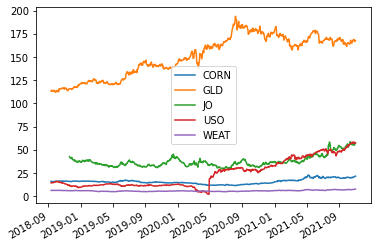

In [301]:
port_data.plot()

<AxesSubplot:>

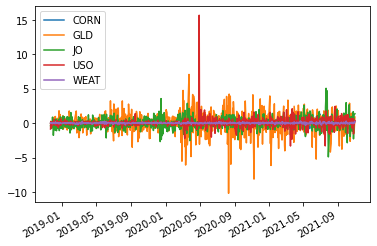

In [305]:
d1_data = port_data.copy().diff().dropna()
d1_data.plot()

In [306]:
#Difference between two rows 
d1_data.head()

,CORN,GLD,JO,USO,WEAT
2018-11-20,-0.04,-0.05,-0.3800,-0.860,0.0200
2018-11-21,0.03,0.25,-0.6200,0.240,-0.0599
2018-11-23,-0.07,-0.13,-0.7501,-0.670,0.0099
2018-11-26,-0.12,-0.11,-0.0698,0.095,0.0650
2018-11-27,0.01,-0.69,0.8699,0.010,-0.0849


In [307]:
from statsmodels.tsa.stattools import kpss, adfuller 

### Look at the p-value and the adfuller to check for stationarity 

In [308]:
#if p-value is less than .05 then adf says the series is stationary
if adfuller(d1_data["CORN"])[1] < 0.05:
    print("stationary")

stationary


In [309]:
if adfuller(d1_data["GLD"])[1] < 0.05:
    print("stationary")

stationary


In [310]:
if adfuller(d1_data["JO"])[1] < 0.05:
    print("stationary")

stationary


In [311]:
if adfuller(d1_data["USO"])[1] < 0.05:
    print("stationary")

stationary


In [312]:
#adfuller(d1_data["WEAT"])

In [313]:
if adfuller(d1_data["WEAT"])[1] < 0.05:
    print("stationary")

stationary


#### Check Stationarity again using the KPSS model to be really thorough 

In [314]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        if "5%" == key:
            print(f'   {key} : {value}')
            print(f'Result: The series is {"not " if statistic >= value else ""}stationary')

kpss_test(d1_data["CORN"], regression="c", nlags="auto") # regression="ct" to test for trend too

KPSS Statistic: 0.39203580149978295
p-value: 0.08058801659492114
num lags: 7
Critial Values:
   5% : 0.463
Result: The series is stationary


In [315]:

from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        if "5%" == key:
            print(f'   {key} : {value}')
            print(f'Result: The series is {"not " if statistic >= value else ""}stationary')

kpss_test(d1_data["GLD"], regression="c", nlags="auto") # regression="ct" to test for trend too

KPSS Statistic: 0.17837675822145382
p-value: 0.1
num lags: 11
Critial Values:
   5% : 0.463
Result: The series is stationary


/Users/jacqueline/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [316]:

from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        if "5%" == key:
            print(f'   {key} : {value}')
            print(f'Result: The series is {"not " if statistic >= value else ""}stationary')

kpss_test(d1_data["USO"], regression="c", nlags="auto") # regression="ct" to test for trend too

KPSS Statistic: 0.28330797000955976
p-value: 0.1
num lags: 2
Critial Values:
   5% : 0.463
Result: The series is stationary


/Users/jacqueline/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [317]:

from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        if "5%" == key:
            print(f'   {key} : {value}')
            print(f'Result: The series is {"not " if statistic >= value else ""}stationary')

kpss_test(d1_data["WEAT"], regression="c", nlags="auto") # regression="ct" to test for trend too

KPSS Statistic: 0.26753808599960577
p-value: 0.1
num lags: 6
Critial Values:
   5% : 0.463
Result: The series is stationary


/Users/jacqueline/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [318]:

from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        if "5%" == key:
            print(f'   {key} : {value}')
            print(f'Result: The series is {"not " if statistic >= value else ""}stationary')

kpss_test(d1_data["JO"], regression="c", nlags="auto") # regression="ct" to test for trend too

KPSS Statistic: 0.2995234890774164
p-value: 0.1
num lags: 4
Critial Values:
   5% : 0.463
Result: The series is stationary


/Users/jacqueline/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [319]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Testing for White Noise 

Revealed that all of the data is autocorrelated, if only by a little

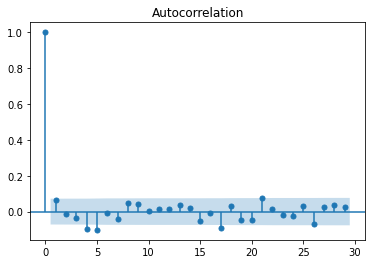

In [320]:
acf = plot_acf(d1_data["GLD"])

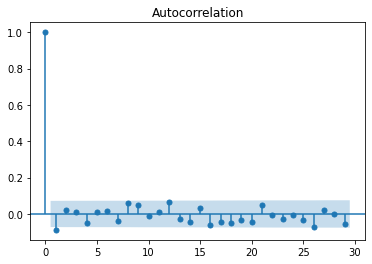

In [321]:
acf = plot_acf(d1_data["WEAT"])

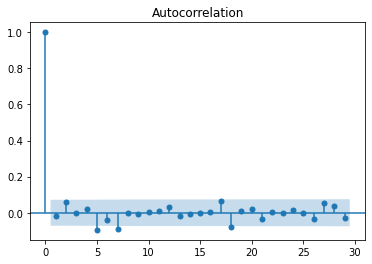

In [322]:
acf = plot_acf(d1_data["JO"])

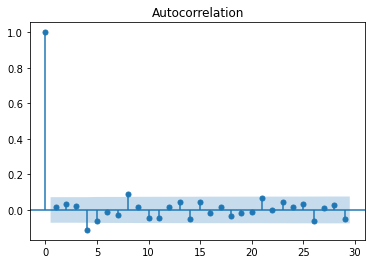

In [323]:
acf = plot_acf(d1_data["CORN"])

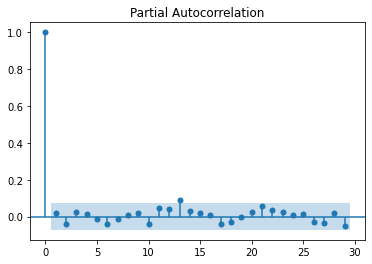

In [324]:
pacf = plot_pacf(d1_data["USO"])

#### Run an ARIMA model 

In [325]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

In [326]:
port_data.head(-1)

,CORN,GLD,JO,USO,WEAT
2018-09-11,16.2400,113.22,NaN,14.600,6.3700
2018-09-12,15.7799,114.17,NaN,14.775,6.2601
2018-09-13,15.7000,113.76,NaN,14.480,6.1800
2018-09-14,15.7100,113.01,NaN,14.500,6.3200
2018-09-17,15.5900,113.61,NaN,14.470,6.2500
...,...,...,...,...,...
2021-10-25,20.4200,168.92,55.75,57.840,7.4300
2021-10-26,20.5100,167.68,57.41,58.470,7.3500
2021-10-27,21.0300,168.13,55.13,56.890,7.4600
2021-10-28,21.2300,168.10,54.93,57.410,7.5600


In [328]:
#Building the model 
data_sample_months = port_data.dropna().copy()

data_sample_months["month"] = data_sample_months.index.month # add a column with values 1-12 for the month

months_dummies = pd.get_dummies(data_sample_months, columns=['month']) # create indicator variable

months_dummies.drop(columns=["CORN", "GLD", "JO", "WEAT", "USO"], inplace=True)

data_sample_months = pd.concat([port_data, months_dummies], axis=1) # join indicator variables

data_sample_months.dropna(inplace=True)

data_sample_months.head()

,CORN,GLD,JO,USO,WEAT,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2018-11-19,16.02,115.67,42.7000,12.140,6.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-11-20,15.98,115.62,42.3200,11.280,6.0200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-11-21,16.01,115.87,41.7000,11.520,5.9601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-11-23,15.94,115.74,40.9499,10.850,5.9700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-11-26,15.82,115.63,40.8801,10.945,6.0350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [332]:
model = ARIMA(data_sample_months["CORN"],
              data_sample_months.drop(columns=["CORN", "WEAT", "GLD", "month_1", "month_11", "month_12", "month_2", "month_10"
                                              ,"month_9", "month_4", "month_3", "month_6", "month_7","month_8", "month_5"]),
             order=([8, 5, 21], 1, [ 4, 5])
              
        )
#res = model.fit()

/Users/jacqueline/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jacqueline/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jacqueline/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [333]:
res = model.fit()

In [334]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                             CORN   No. Observations:                  743
Model:             ARIMA([5, 8, 21], 1, [4, 5])   Log Likelihood                  43.081
Date:                          Mon, 08 Nov 2021   AIC                            -70.162
Time:                                  20:38:28   BIC                            -33.287
Sample:                                       0   HQIC                           -55.946
                                          - 743                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
JO             0.0510      0.008      6.114      0.000       0.035       0.067
USO            0.0268      0.010      2.696      0.007       0.007       0.046
ar.L5          0.2343      0.138      1.695      0.090      -0.037       0.505
ar.L8          0.0987      0.026      3.797      0.000       0.048       0.150
ar.L21         0.0580      0.023      2.567      0.010       0.014       0.102
ma.L4         -0.1018      0.026     -3.980      0.000      -0.152      -0.052
ma.L5         -0.3067      0.135     -2.272      0.023      -0.571      -0.042
sigma2         0.0521      0.002     33.034      0.000       0.049       0.055
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):              1025.78
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               3.57   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Standardized residual for C: looking for the difference between the predicted values and actual values. 
### Histogram plus estimated density: distribution of data... estimation of my data based on random values... 
### Normal Q-Q: 
### Correlogram 

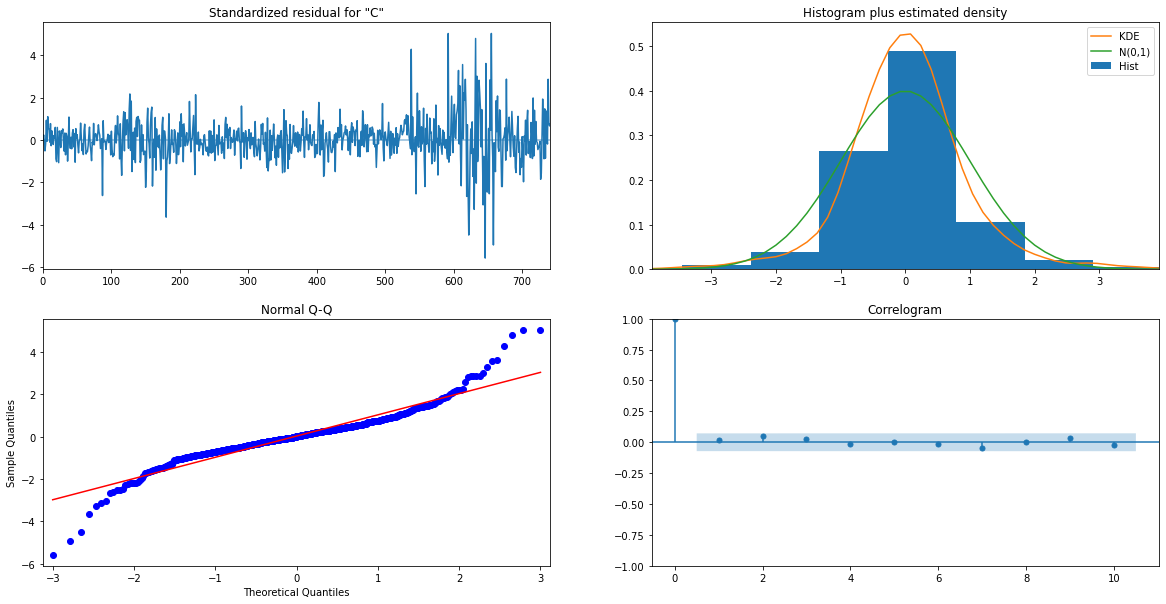

In [335]:
diag_plots = res.plot_diagnostics(figsize=(20,10))



/Users/jacqueline/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jacqueline/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jacqueline/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                        USO   No. Observations:                  743
Model:             ARIMA([13], 1, [4, 5])   Log Likelihood                -901.660
Date:                    Wed, 03 Nov 2021   AIC                           1835.321
Time:                            21:11:43   BIC                           1909.070
Sample:                                 0   HQIC                          1863.752
                                    - 743                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month_1       -0.2737      0.917     -0.298      0.765      -2.072       1.525
month_2       -0.0817      0.887     -0.092      0.927      -1.820       1.657
month_3       -0.3128      0.884     -0.354      0.724      -2.046       1.421
month_4        0.2032      0.914      0.222      0.824      -1.588       1.994
month_5        0.1837      0.999      0.184      0.854      -1.775       2.142
month_6        0.3755      1.069      0.351      0.725      -1.720       2.471
month_7        0.6193      1.221      0.507      0.612      -1.774       3.012
month_8       -0.0715      1.251     -0.057      0.954      -2.524       2.381
month_9       -0.2000      1.278     -0.157      0.876      -2.705       2.305
month_10      -0.4341      1.249     -0.348      0.728      -2.882       2.014
month_11       0.0174      1.100      0.016      0.987      -2.139       2.173
month_12      -0.0260      1.012     -0.026      0.979      -2.009       1.957
ar.L13         0.0829      0.041      2.003      0.045       0.002       0.164
ma.L4          0.0179      0.023      0.788      0.431      -0.027       0.063
ma.L5         -0.0081      0.042     -0.190      0.849      -0.091       0.075
sigma2         0.6652      0.004    161.898      0.000       0.657       0.673
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):           1034286.29
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):              10.31   Skew:                             9.33
Prob(H) (two-sided):                  0.00   Kurtosis:                       184.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.39e+17. Standard errors may be unstable.
"""

,CORN,GLD,JO,USO,WEAT,ewma
time,,,,,,
2018-09-11 00:00:00-04:00,16.2400,113.22,NaN,14.600,6.3700,16.240000
2018-09-12 00:00:00-04:00,15.7799,114.17,NaN,14.775,6.2601,15.983491
2018-09-13 00:00:00-04:00,15.7000,113.76,NaN,14.480,6.1800,15.866523
2018-09-14 00:00:00-04:00,15.7100,113.01,NaN,14.500,6.3200,15.812986
2018-09-17 00:00:00-04:00,15.5900,113.61,NaN,14.470,6.2500,15.745832


<AxesSubplot:>

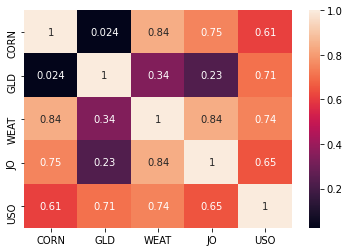

In [338]:
import seaborn as sns
sns.heatmap(data_sample_months[['CORN', 'GLD', 'WEAT', 'JO', 'USO']].corr(), annot=True)

<AxesSubplot:>

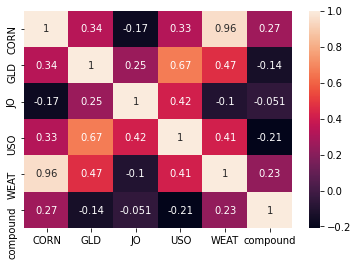

In [340]:
sns.heatmap(one_month_data.corr(), annot=True)

Work Cited
https://medium.com/analytics-vidhya/a-complete-guide-to-twitter-sentiment-analysis-part-two-7349550bdea9